In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
from skimage import filters
from skimage.measure import shannon_entropy
import cv2
import warnings
warnings.filterwarnings("ignore")

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ========================
# 1. Download and Set Up Datasets
# ========================

# Create main directory for datasets
!mkdir -p /content/skin_datasets

# HAM10000 Dataset
print("\n===== Setting up HAM10000 Dataset =====")
!mkdir -p /content/skin_datasets/ham10000

# Download HAM10000 files
print("Downloading HAM10000 dataset...")
!wget -O /content/skin_datasets/ham10000/ISIC2018_Task3_Training_Input.zip https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip
!wget -O /content/skin_datasets/ham10000/ISIC2018_Task3_Training_GroundTruth.zip https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip
!wget -O /content/skin_datasets/ham10000/ISIC2018_Task3_Training_LesionGroupings.csv https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_LesionGroupings.csv

# Extract HAM10000 files
print("Extracting HAM10000 files...")
!unzip -q /content/skin_datasets/ham10000/ISIC2018_Task3_Training_Input.zip -d /content/skin_datasets/ham10000/images
!unzip -q /content/skin_datasets/ham10000/ISIC2018_Task3_Training_GroundTruth.zip -d /content/skin_datasets/ham10000

# ISIC 2019 Dataset
print("\n===== Setting up ISIC 2019 Dataset =====")
!mkdir -p /content/skin_datasets/isic2019

# Download ISIC 2019 files
print("Downloading ISIC 2019 files...")
!wget -O /content/skin_datasets/isic2019/ISIC_2019_Training_Input.zip https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Input.zip
!wget -O /content/skin_datasets/isic2019/ISIC_2019_Training_Metadata.csv https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Metadata.csv
!wget -O /content/skin_datasets/isic2019/ISIC_2019_Training_GroundTruth.csv https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_GroundTruth.csv

# Extract ISIC 2019 files
print("Extracting ISIC 2019 files...")
!mkdir -p /content/skin_datasets/isic2019/images
!unzip -q /content/skin_datasets/isic2019/ISIC_2019_Training_Input.zip -d /content/skin_datasets/isic2019/images



Using device: cuda:0

===== Setting up HAM10000 Dataset =====
--2025-04-20 00:40:39--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 54.231.226.9, 3.5.0.27, 52.216.210.81, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|54.231.226.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2771732744 (2.6G) [application/zip]
Saving to: ‘/content/skin_datasets/ham10000/ISIC2018_Task3_Training_Input.zip’

/content/skin_datas 100%[===================>]   2.58G  57.8MB/s    in 51s     

2025-04-20 00:41:30 (51.9 MB/s) - ‘/content/skin_datasets/ham10000/ISIC2018_Task3_Training_Input.zip’ saved [2771732744/2771732744]

--2025-04-20 00:41:31--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amaz

In [ ]:
from sklearn.model_selection import train_test_split
def build_skin_disease_taxonomy():
    """Build the skin disease taxonomy"""
    # Define taxonomy structure
    taxonomy = {
        "Highly Dangerous": {
            "Malignant Melanoma": ["Superficial spreading melanoma", "Nodular melanoma", "Lentigo maligna melanoma"],
            "Non-Melanoma Skin Cancer": ["Basal cell carcinoma", "Squamous cell carcinoma", "Actinic keratosis"]
        },
        "Minor Conditions": {
            "Benign Lesions": ["Melanocytic nevus", "Dermatofibroma", "Seborrheic keratosis", "Vascular lesions"],
            "Inflammatory Conditions": ["Eczema", "Psoriasis", "Acne", "Rosacea"],
            "Infectious Lesions": ["Fungal infections", "Viral warts", "Bacterial infections"]
        }
    }

    # Create mapping from HAM10000 labels to severity classes
    ham10000_mapping = {
        "MEL": "Highly Dangerous",  # Melanoma
        "BCC": "Highly Dangerous",  # Basal Cell Carcinoma
        "AKIEC": "Highly Dangerous",  # Actinic Keratosis / Intraepithelial Carcinoma
        "SCC": "Highly Dangerous",  # Squamous Cell Carcinoma
        "NV": "Minor Conditions",  # Melanocytic Nevus
        "BKL": "Minor Conditions",  # Benign Keratosis
        "DF": "Minor Conditions",  # Dermatofibroma
        "VASC": "Minor Conditions"  # Vascular Lesions
    }

    return taxonomy, ham10000_mapping

# ========================
# 3. Process and Combine Datasets
# ========================

def process_ham10000():
    """Process HAM10000 dataset and add taxonomy information"""
    # Define paths
    ground_truth_file = "/content/skin_datasets/ham10000/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv"
    lesion_groupings_file = "/content/skin_datasets/ham10000/ISIC2018_Task3_Training_LesionGroupings.csv"

    # Check if files exist
    if not os.path.exists(ground_truth_file):
        print(f"Warning: Ground truth file not found at {ground_truth_file}")
        return pd.DataFrame()

    if not os.path.exists(lesion_groupings_file):
        print(f"Warning: Lesion groupings file not found at {lesion_groupings_file}")
        return pd.DataFrame()

    # Load data files
    ground_truth = pd.read_csv(ground_truth_file)
    lesion_groupings = pd.read_csv(lesion_groupings_file)

    # Get diagnosis columns
    diagnosis_columns = [col for col in ground_truth.columns if col != 'image']

    # Merge datasets and create labels
    merged_data = ground_truth.merge(lesion_groupings, on='image')
    merged_data['label'] = merged_data[diagnosis_columns].idxmax(axis=1)

    # Add image path column
    merged_data['image_path'] = merged_data['image'].apply(
        lambda x: f"/content/skin_datasets/ham10000/images/ISIC2018_Task3_Training_Input/{x}.jpg"
    )

    # Verify that image files exist
    merged_data['image_exists'] = merged_data['image_path'].apply(os.path.exists)
    print(f"HAM10000: {merged_data['image_exists'].sum()}/{len(merged_data)} images found")

    # Keep only existing images
    merged_data = merged_data[merged_data['image_exists']]

    # Add dataset source
    merged_data['dataset_source'] = 'HAM10000'

    # Add severity based on taxonomy
    _, ham10000_mapping = build_skin_disease_taxonomy()
    merged_data['severity'] = merged_data['label'].map(ham10000_mapping)

    return merged_data

def process_isic2019():
    """Process ISIC 2019 dataset and add taxonomy information"""
    # Define paths
    ground_truth_file = "/content/skin_datasets/isic2019/ISIC_2019_Training_GroundTruth.csv"
    metadata_file = "/content/skin_datasets/isic2019/ISIC_2019_Training_Metadata.csv"

    # Check if files exist
    if not os.path.exists(ground_truth_file):
        print(f"Warning: Ground truth file not found at {ground_truth_file}")
        return pd.DataFrame()

    if not os.path.exists(metadata_file):
        print(f"Warning: Metadata file not found at {metadata_file}")
        return pd.DataFrame()

    # Load data files
    ground_truth = pd.read_csv(ground_truth_file)
    metadata = pd.read_csv(metadata_file)

    # Print column names for debugging
    print("Ground truth columns:", ground_truth.columns.tolist())
    print("Metadata columns:", metadata.columns.tolist())

    # Fix column naming inconsistencies
    # ISIC 2019 data might use 'image_name' or 'image' for the image identifier
    if 'image' not in ground_truth.columns and 'image_name' in ground_truth.columns:
        ground_truth.rename(columns={'image_name': 'image'}, inplace=True)

    if 'image' not in metadata.columns and 'image_name' in metadata.columns:
        pass  # Keep as is, we'll handle the merge
    elif 'image_name' not in metadata.columns and 'image' in metadata.columns:
        metadata.rename(columns={'image': 'image_name'}, inplace=True)

    # Identify diagnosis columns (all except image identifier)
    diagnosis_columns = [col for col in ground_truth.columns if col != 'image']

    # Create labels based on maximum probability
    ground_truth['label'] = ground_truth[diagnosis_columns].idxmax(axis=1)

    # Merge with metadata - handle different column names
    if 'image_name' in metadata.columns:
        # If there's an image_name column in metadata, merge on that
        merged_data = ground_truth.merge(metadata, left_on='image', right_on='image_name', how='left')
    else:
        # Otherwise try direct merge
        merged_data = ground_truth.merge(metadata, on='image', how='left')

    # Add image path column
    merged_data['image_path'] = merged_data['image'].apply(
        lambda x: f"/content/skin_datasets/isic2019/images/ISIC_2019_Training_Input/{x}.jpg"
    )

    # Verify that image files exist
    merged_data['image_exists'] = merged_data['image_path'].apply(os.path.exists)
    print(f"ISIC2019: {merged_data['image_exists'].sum()}/{len(merged_data)} images found")

    # Keep only existing images
    merged_data = merged_data[merged_data['image_exists']]

    # Add dataset source
    merged_data['dataset_source'] = 'ISIC2019'

    # Define mapping from ISIC2019 to HAM10000 labels for consistency
    isic2019_mapping = {
        'MEL': 'MEL',
        'NV': 'NV',
        'BCC': 'BCC',
        'AK': 'AKIEC',
        'BKL': 'BKL',
        'DF': 'DF',
        'SCC': 'SCC',
        'VASC': 'VASC'
    }

    # Apply mapping
    merged_data['label'] = merged_data['label'].map(lambda x: isic2019_mapping.get(x, x))

    # Add severity based on taxonomy
    _, ham10000_mapping = build_skin_disease_taxonomy()
    merged_data['severity'] = merged_data['label'].map(ham10000_mapping)

    return merged_data

def combine_datasets():
    """Combine all datasets and create a unified dataframe"""
    print("Processing HAM10000 dataset...")
    ham10000_df = process_ham10000()

    print("Processing ISIC2019 dataset...")
    isic2019_df = process_isic2019()

    # Initialize an empty list to store dataframes
    dfs = []

    # Add dataframes if they're not empty
    if not ham10000_df.empty:
        dfs.append(ham10000_df)
        print(f"HAM10000 dataset: {len(ham10000_df)} images")

    if not isic2019_df.empty:
        dfs.append(isic2019_df)
        print(f"ISIC2019 dataset: {len(isic2019_df)} images")

    # Check if we have any data
    if not dfs:
        raise ValueError("No valid datasets found. Please check paths and data files.")

    # Combine datasets
    print("Combining datasets...")
    combined_df = pd.concat(dfs, ignore_index=True)

    # Drop duplicates based on image path
    combined_df = combined_df.drop_duplicates(subset=['image_path'])

    print(f"Combined dataset created with {len(combined_df)} images")

    # Print class distribution
    print("\nClass distribution by label:")
    label_counts = combined_df['label'].value_counts()
    for label, count in label_counts.items():
        print(f"  {label}: {count} images ({count/len(combined_df)*100:.1f}%)")

    print("\nClass distribution by severity:")
    severity_counts = combined_df['severity'].value_counts()
    for severity, count in severity_counts.items():
        print(f"  {severity}: {count} images ({count/len(combined_df)*100:.1f}%)")

    return combined_df

# ========================
# 4. Denoising and Image Quality Assessment
# ========================

def assess_image_quality(image_path):
    """Assess image quality for filtering low-quality images"""
    try:
        # Read image
        img = cv2.imread(image_path)
        if img is None:
            return False

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Calculate sharpness (Laplacian variance)
        laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()

        # Calculate entropy
        entropy = shannon_entropy(gray)

        # Calculate contrast
        contrast = gray.std()

        # Simple thresholding to separate potential lesion
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        lesion_area = np.sum(thresh == 255)
        total_area = thresh.size
        lesion_ratio = lesion_area / total_area

        # Define quality criteria
        is_sharp = laplacian_var > 50  # Good sharpness
        has_good_entropy = entropy > 2  # Contains meaningful information
        good_contrast = contrast > 20  # Sufficient contrast
        good_lesion_focus = 0.05 < lesion_ratio < 0.95  # Lesion is visible but not too large or small

        # Consider image good quality if it meets most criteria
        quality_score = sum([is_sharp, has_good_entropy, good_contrast, good_lesion_focus])
        return quality_score >= 3

    except Exception as e:
        print(f"Error assessing image {image_path}: {str(e)}")
        return False

def denoise_dataset(combined_df):
    """Remove low-quality images from the dataset"""
    print("Assessing image quality...")

    # Ensure image_path exists
    if 'image_path' not in combined_df.columns:
        print("Error: 'image_path' column not found in dataframe")
        return combined_df

    # Sample a subset of images for quality assessment to save time
    sample_size = min(1000, len(combined_df))
    sample_df = combined_df.sample(sample_size, random_state=42)

    # Assess quality of sampled images
    quality_results = []
    for idx, row in sample_df.iterrows():
        image_path = row['image_path']
        quality = assess_image_quality(image_path)
        quality_results.append(quality)

    # Calculate quality rate
    quality_rate = sum(quality_results) / len(quality_results)
    print(f"Image quality assessment: {sum(quality_results)}/{len(quality_results)} images passed ({quality_rate:.1%})")

    # If quality is generally good, keep all images
    if quality_rate > 0.9:
        print("Most images have good quality. Keeping all images.")
        return combined_df

    # Otherwise, assess all images and filter
    print("Filtering low-quality images...")
    combined_df['good_quality'] = False  # Initialize column

    # Process in chunks to show progress
    chunk_size = 1000
    total_chunks = len(combined_df) // chunk_size + 1

    for i in range(total_chunks):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, len(combined_df))
        chunk = combined_df.iloc[start_idx:end_idx]

        # Process chunk
        print(f"Processing chunk {i+1}/{total_chunks} ({start_idx} to {end_idx})...")
        for idx, row in chunk.iterrows():
            image_path = row['image_path']
            combined_df.at[idx, 'good_quality'] = assess_image_quality(image_path)

    # Filter dataframe
    filtered_df = combined_df[combined_df['good_quality']]

    print(f"After filtering: {len(filtered_df)}/{len(combined_df)} images kept ({len(filtered_df)/len(combined_df):.1%})")
    return filtered_df

# ========================
# 5. Disease Partitioning and Training Classes
# ========================

def create_training_classes(df, max_classes=7, min_samples=50):
    """Partition diseases into balanced training classes"""
    print("Creating training classes...")

    # Check if df is empty
    if len(df) == 0:
        print("Error: Empty dataframe provided")
        return df

    # Check if required columns exist
    required_cols = ['severity', 'label']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"Error: Missing columns: {missing_cols}")
        return df

    # Start with severity-based classes
    df['training_class'] = df['severity']

    # Get label distribution within each severity class
    high_danger_labels = df[df['severity'] == 'Highly Dangerous']['label'].value_counts()
    minor_labels = df[df['severity'] == 'Minor Conditions']['label'].value_counts()

    # For high danger classes, separate major cancer types
    for label, count in high_danger_labels.items():
        if count >= min_samples:
            # Create a specific class for this cancer type
            mask = (df['label'] == label)
            df.loc[mask, 'training_class'] = f"Dangerous: {label}"

    # For minor conditions, group common conditions
    for label, count in minor_labels.items():
        if count >= min_samples:
            # Create a specific class for this condition
            mask = (df['label'] == label)
            df.loc[mask, 'training_class'] = f"Minor: {label}"

    # Check resulting class distribution
    class_counts = df['training_class'].value_counts()
    print("\nTraining class distribution:")
    for cls, count in class_counts.items():
        print(f"  {cls}: {count} images ({count/len(df)*100:.1f}%)")

    # If we have too many classes, merge smaller ones
    if len(class_counts) > max_classes:
        print(f"\nToo many classes ({len(class_counts)}). Merging smaller classes...")

        # Keep largest classes, merge smaller ones
        top_classes = class_counts.head(max_classes - 1).index.tolist()

        # Update training classes, merging smaller ones
        df['training_class'] = df['training_class'].apply(
            lambda x: x if x in top_classes else "Other conditions"
        )

        # Print updated distribution
        class_counts = df['training_class'].value_counts()
        print("\nRevised training class distribution:")
        for cls, count in class_counts.items():
            print(f"  {cls}: {count} images ({count/len(df)*100:.1f}%)")

    return df

# ========================
# 6. Dataset and DataLoader
# ========================

class SkinLesionDataset(Dataset):
    """Dataset class for skin lesion images"""
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

        # Create class mapping
        self.classes = sorted(dataframe['training_class'].unique())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        # Map training classes to indices
        self.dataframe['class_idx'] = self.dataframe['training_class'].map(self.class_to_idx)

        print(f"Dataset created with {len(self.dataframe)} images and {len(self.classes)} classes")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        class_idx = self.dataframe.iloc[idx]['class_idx']

        # Load image
        try:
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            # Create a black dummy image if file can't be read
            img = Image.new('RGB', (224, 224), color='black')

        # Apply transformations
        if self.transform:
            img = self.transform(img)

        return img, class_idx

def create_data_loaders(df, batch_size=32):
    """Create training, validation, and test data loaders"""
    # Check if dataframe is empty or missing required columns
    if len(df) == 0:
        raise ValueError("Empty dataframe provided")

    if 'training_class' not in df.columns:
        raise ValueError("Missing 'training_class' column")

    # Split data into train, validation, and test sets
    train_df, temp_df = train_test_split(
        df, test_size=0.3, random_state=42, stratify=df['training_class']
    )

    val_df, test_df = train_test_split(
        temp_df, test_size=0.5, random_state=42, stratify=temp_df['training_class']
    )

    print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

    # Data augmentation for training
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Validation and test transforms
    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Create datasets
    train_dataset = SkinLesionDataset(train_df, transform=train_transform)
    val_dataset = SkinLesionDataset(val_df, transform=val_test_transform)
    test_dataset = SkinLesionDataset(test_df, transform=val_test_transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

    return train_loader, val_loader, test_loader, train_dataset.classes

# ========================
# 7. CNN Model Architecture (Inception v3)
# ========================

def create_inception_model(num_classes):
    """Create Inception v3 model with custom classifier head"""
    # Load pretrained Inception v3
    model = models.inception_v3(pretrained=True)

    # Modify final classifier
    # Inception v3 has both main output and auxiliary output
    # We need to modify both for fine-tuning

    # Modify main classifier
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    # Modify auxiliary classifier
    if hasattr(model, 'AuxLogits') and hasattr(model.AuxLogits, 'fc'):
        aux_in_features = model.AuxLogits.fc.in_features
        model.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

    return model

# ========================
# 8. Training Functions
# ========================

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=25):
    """Train the CNN model"""
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # For tracking training progress
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    # Special case for Inception v3 (has auxiliary output)
                    if isinstance(model, models.inception.Inception3) and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # Backward pass and optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            # Store history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if best validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

# ========================
# 9. Evaluation Functions
# ========================

def evaluate_model(model, test_loader, class_names):
    """Evaluate the model on test data"""
    model.eval()

    # Initialize variables for evaluation
    all_preds = []
    all_labels = []
    running_corrects = 0

    # Iterate over test data
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Update statistics
            running_corrects += torch.sum(preds == labels.data)

            # Store predictions and labels for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    test_acc = running_corrects.double() / len(test_loader.dataset)
    print(f'Test Accuracy: {test_acc:.4f}')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    return test_acc, cm

def plot_training_history(history):
    """Plot training and validation loss/accuracy"""
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# ========================
# 10. Main Execution
# ========================

def main():
    try:
        # 1. Combine datasets
        combined_df = combine_datasets()

        # Make sure we have some data
        if len(combined_df) == 0:
            raise ValueError("No data available after combining datasets")

        # 2. Filter low-quality images
        denoised_df = denoise_dataset(combined_df)

        # 3. Create training classes
        classified_df = create_training_classes(denoised_df)

        # 4. Create data loaders
        train_loader, val_loader, test_loader, class_names = create_data_loaders(classified_df)

        # 5. Create model
        num_classes = len(class_names)
        model = create_inception_model(num_classes)
        model = model.to(device)

        # 6. Set up loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

        # Learning rate scheduler
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        # 7. Train model
        model, history = train_model(
            model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15
        )

        # 8. Plot training history
        plot_training_history(history)

        # 9. Evaluate model
        test_acc, cm = evaluate_model(model, test_loader, class_names)

        # 10. Save model
        torch.save(model.state_dict(), '/content/skin_lesion_classifier.pth')
        print("Model saved to '/content/skin_lesion_classifier.pth'")

        return model, class_names

    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None



In [ ]:
IMAGE_SIZE = 224  # Changed from 224 to 299 for Inception v3
BATCH_SIZE = 64   # Reduced batch size for stability
NUM_EPOCHS = 10   # Can be reduced for faster debugging
MODEL_TYPE = "resnet50"  # Options: "inception_v3", "resnet50", "efficientnet"
#5. Disease Partitioning and Training Classes
# ========================

def create_training_classes(df, max_classes=7, min_samples=50):
    """Partition diseases into balanced training classes"""
    print("Creating training classes...")

    # Check if df is empty
    if len(df) == 0:
        print("Error: Empty dataframe provided")
        return df

    # Check if required columns exist
    required_cols = ['severity', 'label']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"Error: Missing columns: {missing_cols}")
        return df

    # Start with severity-based classes
    df['training_class'] = df['severity']

    # Get label distribution within each severity class
    high_danger_labels = df[df['severity'] == 'Highly Dangerous']['label'].value_counts()
    minor_labels = df[df['severity'] == 'Minor Conditions']['label'].value_counts()

    # For high danger classes, separate major cancer types
    for label, count in high_danger_labels.items():
        if count >= min_samples:
            # Create a specific class for this cancer type
            mask = (df['label'] == label)
            df.loc[mask, 'training_class'] = f"Dangerous: {label}"

    # For minor conditions, group common conditions
    for label, count in minor_labels.items():
        if count >= min_samples:
            # Create a specific class for this condition
            mask = (df['label'] == label)
            df.loc[mask, 'training_class'] = f"Minor: {label}"

    # Check resulting class distribution
    class_counts = df['training_class'].value_counts()
    print("\nTraining class distribution:")
    for cls, count in class_counts.items():
        print(f"  {cls}: {count} images ({count/len(df)*100:.1f}%)")

    # If we have too many classes, merge smaller ones
    if len(class_counts) > max_classes:
        print(f"\nToo many classes ({len(class_counts)}). Merging smaller classes...")

        # Keep largest classes, merge smaller ones
        top_classes = class_counts.head(max_classes - 1).index.tolist()

        # Update training classes, merging smaller ones
        df['training_class'] = df['training_class'].apply(
            lambda x: x if x in top_classes else "Other conditions"
        )

        # Print updated distribution
        class_counts = df['training_class'].value_counts()
        print("\nRevised training class distribution:")
        for cls, count in class_counts.items():
            print(f"  {cls}: {count} images ({count/len(df)*100:.1f}%)")

    return df

# ========================
# 6. Dataset and DataLoader
# ========================

class SkinLesionDataset(Dataset):
    """Dataset class for skin lesion images"""
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

        # Create class mapping
        self.classes = sorted(dataframe['training_class'].unique())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        # Map training classes to indices
        self.dataframe['class_idx'] = self.dataframe['training_class'].map(self.class_to_idx)

        print(f"Dataset created with {len(self.dataframe)} images and {len(self.classes)} classes")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        class_idx = self.dataframe.iloc[idx]['class_idx']

        # Load image
        try:
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            # Create a black dummy image if file can't be read
            img = Image.new('RGB', (224, 224), color='black')

        # Apply transformations
        if self.transform:
            img = self.transform(img)

        return img, class_idx

def get_transforms(image_size):
    """Get train and validation/test transforms with specified image size"""
    train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    val_test_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    return train_transform, val_test_transform

def create_data_loaders(df, batch_size=32):
    """Create training, validation, and test data loaders"""
    # Check if dataframe is empty or missing required columns
    if len(df) == 0:
        raise ValueError("Empty dataframe provided")

    if 'training_class' not in df.columns:
        raise ValueError("Missing 'training_class' column")

    # Split data into train, validation, and test sets
    train_df, temp_df = train_test_split(
        df, test_size=0.3, random_state=42, stratify=df['training_class']
    )

    val_df, test_df = train_test_split(
        temp_df, test_size=0.5, random_state=42, stratify=temp_df['training_class']
    )

    print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

    # Data augmentation for training
    train_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Changed from 224x224 to 299x299 for Inception v3
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

    # Validation and test transforms
    val_test_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Changed from 224x224 to 299x299
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

    # Create datasets
    train_dataset = SkinLesionDataset(train_df, transform=train_transform)
    val_dataset = SkinLesionDataset(val_df, transform=val_test_transform)
    test_dataset = SkinLesionDataset(test_df, transform=val_test_transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

    return train_loader, val_loader, test_loader, train_dataset.classes

def train_with_mixed_precision(model, train_loader, val_loader, criterion,
                              optimizer, scheduler=None, num_epochs=10, device=None):
    """Optimized training with mixed precision and reduced logging"""
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Use mixed precision
    from torch.cuda.amp import autocast, GradScaler
    scaler = GradScaler()

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Only log every N batches (to reduce overhead)
    log_every = 50

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Use tqdm for progress bar
            from tqdm import tqdm

            for batch_idx, (inputs, labels) in enumerate(tqdm(dataloader, desc=f"{phase}")):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero gradients
                optimizer.zero_grad()

                # Mixed precision forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    with autocast(enabled=device.type=='cuda'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # Backward + optimize only in training phase
                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                # Statistics
                batch_loss = loss.item()
                running_loss += batch_loss * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Print progress occasionally
                if phase == 'train' and (batch_idx + 1) % log_every == 0:
                    samples_so_far = (batch_idx + 1) * inputs.size(0)
                    running_acc = running_corrects.double() / samples_so_far
                    print(f"\nBatch {batch_idx + 1}/{len(dataloader)}: Loss: {batch_loss:.4f}, Acc: {running_acc:.4f}")

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            # Store history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
                if scheduler is not None:
                    scheduler.step()
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history
# ========================
# 7. CNN Model Architecture (Inception v3)
# ========================

def create_model(model_type, num_classes):
    """Create model based on specified type"""
    if model_type == "inception_v3":
        # Inception v3 requires 299x299 minimum input size
        model = models.inception_v3(pretrained=True)

        # Modify main classifier
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)

        # Modify auxiliary classifier
        if hasattr(model, 'AuxLogits') and hasattr(model.AuxLogits, 'fc'):
            aux_in_features = model.AuxLogits.fc.in_features
            model.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

    elif model_type == "resnet50":
        # ResNet50 - more robust alternative
        model = models.resnet50(pretrained=True)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)

    elif model_type == "mobilenet_v2":
        # MobileNetV2 - much faster than Inception or ResNet
        model = models.mobilenet_v2(pretrained=True)
        # Replace classifier
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)


    elif model_type == "efficientnet":
        # EfficientNet - lighter weight option
        model = models.efficientnet_b0(pretrained=True)
        in_features = model.classifier[1].in_features
        model.classifier = nn.Linear(in_features, num_classes)

    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    return model

# ========================
# 8. Training Functions
# ========================

def train_model(model, train_loader, val_loader, criterion, optimizer,
               scheduler=None, num_epochs=15, device=None, report_interval=10):
    """Train with detailed batch progress reporting"""
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # For tracking training progress
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'batch_losses': [], 'batch_accs': []  # Track individual batch metrics
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 40)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Track batch-level metrics
            batch_losses = []
            batch_accs = []

            # Use tqdm for progress bar
            from tqdm import tqdm
            total_batches = len(dataloader)

            # Iterate over data with progress bar
            for batch_idx, (inputs, labels) in enumerate(tqdm(dataloader, desc=f"{phase.capitalize()}")):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    # Special handling for Inception v3
                    if isinstance(model, models.inception.Inception3) and phase == 'train':
                        try:
                            outputs, aux_outputs = model(inputs)
                            loss1 = criterion(outputs, labels)
                            loss2 = criterion(aux_outputs, labels)
                            loss = loss1 + 0.4 * loss2
                        except RuntimeError:
                            # Fall back to main output only
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # Backward pass and optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Calculate batch statistics
                batch_loss = loss.item()
                batch_acc = torch.sum(preds == labels.data).double() / inputs.size(0)

                # Store batch metrics
                batch_losses.append(batch_loss)
                batch_accs.append(batch_acc.item())

                # Update running stats
                running_loss += batch_loss * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Report progress at intervals
                if phase == 'train' and (batch_idx + 1) % report_interval == 0:
                    # Calculate current batch stats
                    print(f"\nBatch {batch_idx + 1}/{total_batches}:")
                    print(f"  Loss: {batch_loss:.4f}")
                    print(f"  Accuracy: {batch_acc:.4f}")

                    # Calculate running stats
                    samples_so_far = (batch_idx + 1) * inputs.size(0)
                    running_loss_avg = running_loss / samples_so_far
                    running_acc_avg = running_corrects.double() / samples_so_far

                    print(f"  Running Loss: {running_loss_avg:.4f}")
                    print(f"  Running Accuracy: {running_acc_avg:.4f}")

                    # Show time elapsed
                    time_elapsed = time.time() - since
                    print(f"  Time: {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")

            # Calculate epoch metrics
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            # Store history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
                history['batch_losses'].extend(batch_losses)
                history['batch_accs'].extend(batch_accs)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if best validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # Step scheduler
        if scheduler is not None and phase == 'train':
            scheduler.step()

        # Plot current progress after each epoch
        if epoch > 0:  # Need at least 2 epochs for plotting
            plt.figure(figsize=(15, 5))

            # Plot accuracy
            plt.subplot(1, 3, 1)
            plt.plot(history['train_acc'], label='Train')
            plt.plot(history['val_acc'], label='Validation')
            plt.title('Model Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()

            # Plot loss
            plt.subplot(1, 3, 2)
            plt.plot(history['train_loss'], label='Train')
            plt.plot(history['val_loss'], label='Validation')
            plt.title('Model Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()

            # Plot batch metrics (last 100 batches)
            plt.subplot(1, 3, 3)
            batch_indices = list(range(len(history['batch_accs'])))
            plt.plot(batch_indices[-100:], history['batch_accs'][-100:], label='Batch Accuracy')
            plt.title('Recent Batch Accuracy')
            plt.xlabel('Batch')
            plt.ylabel('Accuracy')

            plt.tight_layout()
            plt.show()

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

# ========================
# 9. Evaluation Functions
# ========================

def evaluate_model(model, test_loader, class_names):
    """Evaluate the model on test data"""
    model.eval()

    # Initialize variables for evaluation
    all_preds = []
    all_labels = []
    running_corrects = 0

    # Iterate over test data
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Update statistics
            running_corrects += torch.sum(preds == labels.data)

            # Store predictions and labels for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    test_acc = running_corrects.double() / len(test_loader.dataset)
    print(f'Test Accuracy: {test_acc:.4f}')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    return test_acc, cm

def plot_training_history(history):
    """Plot training and validation loss/accuracy"""
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
combined_df = combine_datasets()
if len(combined_df) == 0:
            raise ValueError("No data available after combining datasets")
denoised_df = denoise_dataset(combined_df)
classified_df = create_training_classes(denoised_df)
classified_df.to_csv('/content/processed_skin_data.csv', index=False)

Processing HAM10000 dataset...
HAM10000: 10015/10015 images found
Processing ISIC2019 dataset...
Ground truth columns: ['image', 'MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']
Metadata columns: ['image', 'age_approx', 'anatom_site_general', 'lesion_id', 'sex']
ISIC2019: 25331/25331 images found
HAM10000 dataset: 10015 images
ISIC2019 dataset: 25331 images
Combining datasets...
Combined dataset created with 35346 images

Class distribution by label:
  NV: 19580 images (55.4%)
  MEL: 5635 images (15.9%)
  BCC: 3837 images (10.9%)
  BKL: 3723 images (10.5%)
  AKIEC: 1194 images (3.4%)
  SCC: 628 images (1.8%)
  VASC: 395 images (1.1%)
  DF: 354 images (1.0%)

Class distribution by severity:
  Minor Conditions: 24052 images (68.0%)
  Highly Dangerous: 11294 images (32.0%)
Assessing image quality...
Image quality assessment: 820/1000 images passed (82.0%)
Filtering low-quality images...
Processing chunk 1/36 (0 to 1000)...
Processing chunk 2/36 (1000 to 2000)...
Processing chu

In [ ]:


# Get transforms with the correct image size
train_transform, val_test_transform = get_transforms(IMAGE_SIZE)

# Create data loaders
train_loader, val_loader, test_loader, class_names = create_data_loaders(
    classified_df,
    batch_size=BATCH_SIZE,
)

Train: 20383, Validation: 4368, Test: 4368
Dataset created with 20383 images and 7 classes
Dataset created with 4368 images and 7 classes
Dataset created with 4368 images and 7 classes


In [ ]:
# Step 3: Create and train model (can be modified and rerun)
num_classes = len(class_names)
model = create_model(MODEL_TYPE, num_classes)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Setup optimizer
if MODEL_TYPE == "inception_v3":
    # Lower learning rate for Inception
    optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)
else:
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Sun Apr 20 01:04:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   51C    P0             17W /   72W |     307MiB /  23034MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Train: 20383, Validation: 4368, Test: 4368


100%|██████████| 13.6M/13.6M [00:00<00:00, 125MB/s]


Dataset created with 20383 images and 7 classes
Dataset created with 4368 images and 7 classes
Dataset created with 4368 images and 7 classes
Epoch 1/20
--------------------


train:   8%|▊         | 51/637 [00:08<01:08,  8.53it/s]


Batch 50/637: Loss: 0.8645, Acc: 0.5988


train:  16%|█▌        | 102/637 [00:13<00:47, 11.18it/s]


Batch 100/637: Loss: 0.6725, Acc: 0.6294


train:  24%|██▍       | 152/637 [00:18<00:48,  9.92it/s]


Batch 150/637: Loss: 1.0414, Acc: 0.6417


train:  31%|███▏      | 200/637 [00:23<00:47,  9.28it/s]


Batch 200/637: Loss: 1.0323, Acc: 0.6484


train:  39%|███▉      | 248/637 [00:28<00:41,  9.46it/s]


Batch 250/637: Loss: 0.8300, Acc: 0.6486


train:  47%|████▋     | 299/637 [00:34<00:38,  8.77it/s]


Batch 300/637: Loss: 1.2325, Acc: 0.6510


train:  55%|█████▌    | 353/637 [00:40<00:26, 10.84it/s]


Batch 350/637: Loss: 0.8966, Acc: 0.6538


train:  63%|██████▎   | 399/637 [00:45<00:24,  9.58it/s]


Batch 400/637: Loss: 0.9457, Acc: 0.6569


train:  71%|███████   | 453/637 [00:50<00:16, 11.00it/s]


Batch 450/637: Loss: 0.5642, Acc: 0.6579


train:  78%|███████▊  | 499/637 [00:55<00:14,  9.44it/s]


Batch 500/637: Loss: 0.6818, Acc: 0.6613


train:  86%|████████▋ | 551/637 [01:01<00:10,  8.46it/s]


Batch 550/637: Loss: 0.7208, Acc: 0.6655


train:  94%|█████████▍| 600/637 [01:06<00:04,  8.75it/s]


Batch 600/637: Loss: 0.6557, Acc: 0.6683


train: 100%|██████████| 637/637 [01:10<00:00,  9.06it/s]


train Loss: 0.9107 Acc: 0.6714


val: 100%|██████████| 137/137 [00:15<00:00,  9.13it/s]


val Loss: 0.7853 Acc: 0.7163

Epoch 2/20
--------------------


train:   8%|▊         | 51/637 [00:05<01:05,  8.96it/s]


Batch 50/637: Loss: 0.5215, Acc: 0.7194


train:  16%|█▌        | 99/637 [00:10<00:59,  9.06it/s]


Batch 100/637: Loss: 0.5357, Acc: 0.7184


train:  24%|██▍       | 152/637 [00:16<00:47, 10.15it/s]


Batch 150/637: Loss: 0.6920, Acc: 0.7185


train:  31%|███▏      | 200/637 [00:21<00:50,  8.66it/s]


Batch 200/637: Loss: 0.7809, Acc: 0.7137


train:  39%|███▉      | 251/637 [00:26<00:36, 10.56it/s]


Batch 250/637: Loss: 0.7695, Acc: 0.7160


train:  48%|████▊     | 303/637 [00:32<00:30, 10.79it/s]


Batch 300/637: Loss: 0.7707, Acc: 0.7189


train:  55%|█████▍    | 350/637 [00:37<00:28, 10.18it/s]


Batch 350/637: Loss: 0.6252, Acc: 0.7169


train:  62%|██████▏   | 398/637 [00:42<00:26,  9.01it/s]


Batch 400/637: Loss: 0.7032, Acc: 0.7173


train:  71%|███████   | 450/637 [00:48<00:21,  8.57it/s]


Batch 450/637: Loss: 0.6135, Acc: 0.7190


train:  79%|███████▊  | 501/637 [00:53<00:14,  9.46it/s]


Batch 500/637: Loss: 0.7549, Acc: 0.7206


train:  86%|████████▌ | 549/637 [00:58<00:09,  9.45it/s]


Batch 550/637: Loss: 0.5080, Acc: 0.7206


train:  95%|█████████▍| 603/637 [01:04<00:03, 11.10it/s]


Batch 600/637: Loss: 0.6245, Acc: 0.7224


train: 100%|██████████| 637/637 [01:07<00:00,  9.41it/s]


train Loss: 0.7745 Acc: 0.7228


val: 100%|██████████| 137/137 [00:14<00:00,  9.24it/s]


val Loss: 0.6840 Acc: 0.7500

Epoch 3/20
--------------------


train:   8%|▊         | 52/637 [00:05<00:55, 10.45it/s]


Batch 50/637: Loss: 0.9487, Acc: 0.7325


train:  16%|█▌        | 99/637 [00:10<00:57,  9.33it/s]


Batch 100/637: Loss: 0.7643, Acc: 0.7450


train:  24%|██▍       | 153/637 [00:16<00:47, 10.29it/s]


Batch 150/637: Loss: 0.5913, Acc: 0.7367


train:  32%|███▏      | 201/637 [00:21<00:40, 10.72it/s]


Batch 200/637: Loss: 0.9857, Acc: 0.7347


train:  40%|███▉      | 253/637 [00:27<00:36, 10.57it/s]


Batch 250/637: Loss: 0.6479, Acc: 0.7361


train:  47%|████▋     | 299/637 [00:32<00:40,  8.44it/s]


Batch 300/637: Loss: 0.7277, Acc: 0.7335


train:  55%|█████▌    | 351/637 [00:37<00:33,  8.49it/s]


Batch 350/637: Loss: 1.0046, Acc: 0.7323


train:  63%|██████▎   | 401/637 [00:43<00:24,  9.74it/s]


Batch 400/637: Loss: 0.6367, Acc: 0.7318


train:  71%|███████   | 453/637 [00:48<00:17, 10.80it/s]


Batch 450/637: Loss: 0.6945, Acc: 0.7328


train:  78%|███████▊  | 499/637 [00:53<00:14,  9.60it/s]


Batch 500/637: Loss: 1.2828, Acc: 0.7353


train:  86%|████████▋ | 551/637 [00:58<00:09,  8.70it/s]


Batch 550/637: Loss: 0.7924, Acc: 0.7353


train:  94%|█████████▍| 601/637 [01:03<00:03,  9.68it/s]


Batch 600/637: Loss: 1.1279, Acc: 0.7376


train: 100%|██████████| 637/637 [01:07<00:00,  9.43it/s]


train Loss: 0.7199 Acc: 0.7375


val: 100%|██████████| 137/137 [00:14<00:00,  9.37it/s]


val Loss: 0.7031 Acc: 0.7404

Epoch 4/20
--------------------


train:   8%|▊         | 48/637 [00:05<01:06,  8.85it/s]


Batch 50/637: Loss: 0.5172, Acc: 0.7456


train:  16%|█▌        | 102/637 [00:11<00:49, 10.82it/s]


Batch 100/637: Loss: 1.0516, Acc: 0.7488


train:  24%|██▎       | 150/637 [00:16<00:44, 10.89it/s]


Batch 150/637: Loss: 0.7073, Acc: 0.7471


train:  32%|███▏      | 202/637 [00:21<00:41, 10.56it/s]


Batch 200/637: Loss: 0.7698, Acc: 0.7548


train:  39%|███▉      | 248/637 [00:26<00:41,  9.31it/s]


Batch 250/637: Loss: 0.5320, Acc: 0.7529


train:  47%|████▋     | 302/637 [00:32<00:30, 10.93it/s]


Batch 300/637: Loss: 0.6818, Acc: 0.7539


train:  55%|█████▍    | 350/637 [00:37<00:25, 11.19it/s]


Batch 350/637: Loss: 0.4969, Acc: 0.7571


train:  63%|██████▎   | 400/637 [00:42<00:24,  9.55it/s]


Batch 400/637: Loss: 0.7492, Acc: 0.7550


train:  71%|███████   | 451/637 [00:48<00:20,  9.27it/s]


Batch 450/637: Loss: 0.6217, Acc: 0.7544


train:  79%|███████▉  | 502/637 [00:53<00:12, 10.74it/s]


Batch 500/637: Loss: 0.7276, Acc: 0.7543


train:  86%|████████▌ | 549/637 [00:58<00:08,  9.96it/s]


Batch 550/637: Loss: 0.4738, Acc: 0.7540


train:  94%|█████████▍| 600/637 [01:03<00:03,  9.32it/s]


Batch 600/637: Loss: 0.4154, Acc: 0.7553


train: 100%|██████████| 637/637 [01:07<00:00,  9.40it/s]


train Loss: 0.6746 Acc: 0.7564


val: 100%|██████████| 137/137 [00:14<00:00,  9.33it/s]


val Loss: 0.7197 Acc: 0.7269

Epoch 5/20
--------------------


train:   8%|▊         | 50/637 [00:05<01:01,  9.49it/s]


Batch 50/637: Loss: 0.5911, Acc: 0.7725


train:  16%|█▌        | 99/637 [00:10<00:53, 10.09it/s]


Batch 100/637: Loss: 0.6466, Acc: 0.7712


train:  24%|██▎       | 150/637 [00:16<00:56,  8.63it/s]


Batch 150/637: Loss: 0.7944, Acc: 0.7656


train:  31%|███▏      | 200/637 [00:21<00:39, 11.06it/s]


Batch 200/637: Loss: 0.5901, Acc: 0.7680


train:  39%|███▉      | 250/637 [00:26<00:43,  8.97it/s]


Batch 250/637: Loss: 0.8166, Acc: 0.7649


train:  47%|████▋     | 298/637 [00:31<00:36,  9.20it/s]


Batch 300/637: Loss: 0.5182, Acc: 0.7677


train:  55%|█████▌    | 352/637 [00:37<00:25, 11.38it/s]


Batch 350/637: Loss: 0.3711, Acc: 0.7704


train:  63%|██████▎   | 400/637 [00:42<00:21, 11.23it/s]


Batch 400/637: Loss: 0.6915, Acc: 0.7682


train:  71%|███████   | 451/637 [00:47<00:20,  9.23it/s]


Batch 450/637: Loss: 0.4791, Acc: 0.7681


train:  78%|███████▊  | 498/637 [00:52<00:14,  9.28it/s]


Batch 500/637: Loss: 0.7362, Acc: 0.7678


train:  87%|████████▋ | 552/637 [00:58<00:07, 10.69it/s]


Batch 550/637: Loss: 0.7849, Acc: 0.7688


train:  94%|█████████▍| 601/637 [01:03<00:04,  8.73it/s]


Batch 600/637: Loss: 0.5309, Acc: 0.7698


train: 100%|██████████| 637/637 [01:07<00:00,  9.47it/s]


train Loss: 0.6390 Acc: 0.7700


val: 100%|██████████| 137/137 [00:14<00:00,  9.31it/s]


val Loss: 0.6509 Acc: 0.7674

Epoch 6/20
--------------------


train:   8%|▊         | 52/637 [00:05<00:52, 11.17it/s]


Batch 50/637: Loss: 0.7782, Acc: 0.8013


train:  16%|█▌        | 102/637 [00:11<00:49, 10.74it/s]


Batch 100/637: Loss: 0.5753, Acc: 0.7959


train:  24%|██▎       | 151/637 [00:16<00:53,  9.12it/s]


Batch 150/637: Loss: 0.6812, Acc: 0.7892


train:  32%|███▏      | 202/637 [00:21<00:44,  9.78it/s]


Batch 200/637: Loss: 0.5682, Acc: 0.7844


train:  40%|███▉      | 252/637 [00:26<00:36, 10.61it/s]


Batch 250/637: Loss: 0.4552, Acc: 0.7836


train:  47%|████▋     | 302/637 [00:32<00:34,  9.83it/s]


Batch 300/637: Loss: 0.5877, Acc: 0.7811


train:  55%|█████▍    | 348/637 [00:37<00:32,  8.93it/s]


Batch 350/637: Loss: 0.7287, Acc: 0.7803


train:  63%|██████▎   | 402/637 [00:42<00:22, 10.39it/s]


Batch 400/637: Loss: 0.4283, Acc: 0.7808


train:  70%|███████   | 448/637 [00:47<00:19,  9.66it/s]


Batch 450/637: Loss: 0.7360, Acc: 0.7819


train:  78%|███████▊  | 499/637 [00:52<00:14,  9.39it/s]


Batch 500/637: Loss: 0.6290, Acc: 0.7807


train:  86%|████████▋ | 551/637 [00:58<00:08, 10.37it/s]


Batch 550/637: Loss: 0.5151, Acc: 0.7801


train:  94%|█████████▍| 601/637 [01:03<00:03, 10.25it/s]


Batch 600/637: Loss: 0.5540, Acc: 0.7812


train: 100%|██████████| 637/637 [01:07<00:00,  9.46it/s]


train Loss: 0.6077 Acc: 0.7810


val: 100%|██████████| 137/137 [00:14<00:00,  9.50it/s]


val Loss: 0.6504 Acc: 0.7699

Epoch 7/20
--------------------


train:   8%|▊         | 51/637 [00:06<01:02,  9.31it/s]


Batch 50/637: Loss: 0.8031, Acc: 0.7975


train:  15%|█▌        | 98/637 [00:11<01:01,  8.78it/s]


Batch 100/637: Loss: 0.6143, Acc: 0.7916


train:  24%|██▍       | 152/637 [00:16<00:46, 10.40it/s]


Batch 150/637: Loss: 0.4272, Acc: 0.7888


train:  31%|███▏      | 200/637 [00:21<00:39, 11.07it/s]


Batch 200/637: Loss: 0.6082, Acc: 0.7950


train:  40%|███▉      | 252/637 [00:27<00:38, 10.13it/s]


Batch 250/637: Loss: 0.2637, Acc: 0.7949


train:  47%|████▋     | 301/637 [00:32<00:35,  9.49it/s]


Batch 300/637: Loss: 0.7518, Acc: 0.7953


train:  55%|█████▌    | 352/637 [00:37<00:24, 11.42it/s]


Batch 350/637: Loss: 0.4193, Acc: 0.7947


train:  63%|██████▎   | 400/637 [00:43<00:23, 10.19it/s]


Batch 400/637: Loss: 0.7284, Acc: 0.7916


train:  71%|███████   | 451/637 [00:48<00:18, 10.14it/s]


Batch 450/637: Loss: 0.3821, Acc: 0.7884


train:  78%|███████▊  | 500/637 [00:54<00:12, 11.18it/s]


Batch 500/637: Loss: 0.7608, Acc: 0.7894


train:  86%|████████▋ | 550/637 [00:59<00:09,  9.10it/s]


Batch 550/637: Loss: 0.6025, Acc: 0.7899


train:  94%|█████████▍| 598/637 [01:04<00:04,  9.05it/s]


Batch 600/637: Loss: 0.5276, Acc: 0.7916


train: 100%|██████████| 637/637 [01:08<00:00,  9.29it/s]


train Loss: 0.5703 Acc: 0.7918


val: 100%|██████████| 137/137 [00:14<00:00,  9.52it/s]


val Loss: 0.5897 Acc: 0.7823

Epoch 8/20
--------------------


train:   8%|▊         | 51/637 [00:05<00:56, 10.44it/s]


Batch 50/637: Loss: 0.4799, Acc: 0.8087


train:  16%|█▌        | 99/637 [00:10<00:51, 10.38it/s]


Batch 100/637: Loss: 0.4238, Acc: 0.8153


train:  23%|██▎       | 149/637 [00:15<00:54,  8.89it/s]


Batch 150/637: Loss: 0.3779, Acc: 0.8106


train:  32%|███▏      | 203/637 [00:21<00:40, 10.82it/s]


Batch 200/637: Loss: 0.7024, Acc: 0.8095


train:  39%|███▉      | 251/637 [00:26<00:37, 10.33it/s]


Batch 250/637: Loss: 0.5504, Acc: 0.8085


train:  47%|████▋     | 301/637 [00:31<00:35,  9.55it/s]


Batch 300/637: Loss: 0.3152, Acc: 0.8081


train:  55%|█████▍    | 349/637 [00:36<00:29,  9.82it/s]


Batch 350/637: Loss: 0.7081, Acc: 0.8068


train:  63%|██████▎   | 403/637 [00:42<00:20, 11.32it/s]


Batch 400/637: Loss: 0.6645, Acc: 0.8060


train:  70%|███████   | 448/637 [00:47<00:21,  8.88it/s]


Batch 450/637: Loss: 0.6492, Acc: 0.8063


train:  79%|███████▊  | 501/637 [00:52<00:13, 10.27it/s]


Batch 500/637: Loss: 0.5193, Acc: 0.8066


train:  86%|████████▋ | 551/637 [00:57<00:08,  9.71it/s]


Batch 550/637: Loss: 0.3899, Acc: 0.8060


train:  94%|█████████▍| 601/637 [01:03<00:03,  9.19it/s]


Batch 600/637: Loss: 0.4706, Acc: 0.8052


train: 100%|██████████| 637/637 [01:07<00:00,  9.50it/s]


train Loss: 0.5326 Acc: 0.8048


val: 100%|██████████| 137/137 [00:14<00:00,  9.35it/s]


val Loss: 0.5612 Acc: 0.7983

Epoch 9/20
--------------------


train:   8%|▊         | 50/637 [00:05<01:10,  8.34it/s]


Batch 50/637: Loss: 0.3763, Acc: 0.8394


train:  16%|█▌        | 100/637 [00:11<00:55,  9.67it/s]


Batch 100/637: Loss: 0.4896, Acc: 0.8322


train:  24%|██▎       | 150/637 [00:16<00:55,  8.73it/s]


Batch 150/637: Loss: 0.3832, Acc: 0.8254


train:  31%|███       | 198/637 [00:21<00:46,  9.44it/s]


Batch 200/637: Loss: 0.5554, Acc: 0.8267


train:  40%|███▉      | 252/637 [00:27<00:34, 11.02it/s]


Batch 250/637: Loss: 0.6790, Acc: 0.8197


train:  47%|████▋     | 300/637 [00:32<00:32, 10.34it/s]


Batch 300/637: Loss: 0.7129, Acc: 0.8181


train:  55%|█████▌    | 352/637 [00:37<00:27, 10.38it/s]


Batch 350/637: Loss: 0.4593, Acc: 0.8173


train:  63%|██████▎   | 402/637 [00:43<00:22, 10.47it/s]


Batch 400/637: Loss: 0.5171, Acc: 0.8180


train:  71%|███████   | 451/637 [00:48<00:17, 10.38it/s]


Batch 450/637: Loss: 0.6377, Acc: 0.8181


train:  79%|███████▊  | 501/637 [00:53<00:13, 10.39it/s]


Batch 500/637: Loss: 0.9354, Acc: 0.8169


train:  86%|████████▋ | 550/637 [00:58<00:08, 10.83it/s]


Batch 550/637: Loss: 0.3337, Acc: 0.8156


train:  94%|█████████▍| 600/637 [01:04<00:04,  9.01it/s]


Batch 600/637: Loss: 0.8427, Acc: 0.8160


train: 100%|██████████| 637/637 [01:07<00:00,  9.38it/s]


train Loss: 0.5077 Acc: 0.8151


val: 100%|██████████| 137/137 [00:14<00:00,  9.40it/s]


val Loss: 0.6329 Acc: 0.7882

Epoch 10/20
--------------------


train:   8%|▊         | 50/637 [00:05<01:00,  9.76it/s]


Batch 50/637: Loss: 0.3381, Acc: 0.8275


train:  16%|█▌        | 103/637 [00:11<00:49, 10.86it/s]


Batch 100/637: Loss: 0.4046, Acc: 0.8209


train:  24%|██▎       | 151/637 [00:16<00:47, 10.30it/s]


Batch 150/637: Loss: 0.3195, Acc: 0.8217


train:  31%|███▏      | 200/637 [00:21<00:48,  9.09it/s]


Batch 200/637: Loss: 0.6427, Acc: 0.8245


train:  39%|███▉      | 250/637 [00:26<00:37, 10.32it/s]


Batch 250/637: Loss: 0.5245, Acc: 0.8257


train:  47%|████▋     | 302/637 [00:32<00:28, 11.66it/s]


Batch 300/637: Loss: 0.4047, Acc: 0.8242


train:  55%|█████▍    | 350/637 [00:37<00:26, 10.99it/s]


Batch 350/637: Loss: 0.7069, Acc: 0.8245


train:  63%|██████▎   | 400/637 [00:42<00:25,  9.44it/s]


Batch 400/637: Loss: 0.6710, Acc: 0.8212


train:  70%|███████   | 449/637 [00:47<00:20,  9.39it/s]


Batch 450/637: Loss: 0.6391, Acc: 0.8210


train:  78%|███████▊  | 500/637 [00:52<00:12, 11.03it/s]


Batch 500/637: Loss: 0.5296, Acc: 0.8210


train:  87%|████████▋ | 552/637 [00:58<00:07, 11.05it/s]


Batch 550/637: Loss: 0.7974, Acc: 0.8201


train:  94%|█████████▍| 600/637 [01:03<00:03, 10.59it/s]


Batch 600/637: Loss: 0.5335, Acc: 0.8195


train: 100%|██████████| 637/637 [01:07<00:00,  9.40it/s]


train Loss: 0.4925 Acc: 0.8196


val: 100%|██████████| 137/137 [00:14<00:00,  9.21it/s]


val Loss: 0.5551 Acc: 0.7956

Epoch 11/20
--------------------


train:   8%|▊         | 52/637 [00:05<00:52, 11.21it/s]


Batch 50/637: Loss: 0.2922, Acc: 0.8500


train:  16%|█▌        | 102/637 [00:11<00:52, 10.19it/s]


Batch 100/637: Loss: 0.6625, Acc: 0.8522


train:  24%|██▎       | 150/637 [00:16<00:43, 11.13it/s]


Batch 150/637: Loss: 0.5486, Acc: 0.8479


train:  32%|███▏      | 202/637 [00:21<00:39, 10.90it/s]


Batch 200/637: Loss: 0.3534, Acc: 0.8453


train:  39%|███▉      | 250/637 [00:26<00:44,  8.64it/s]


Batch 250/637: Loss: 0.5689, Acc: 0.8440


train:  47%|████▋     | 298/637 [00:31<00:35,  9.43it/s]


Batch 300/637: Loss: 0.3870, Acc: 0.8405


train:  55%|█████▌    | 352/637 [00:37<00:25, 10.99it/s]


Batch 350/637: Loss: 0.3996, Acc: 0.8414


train:  63%|██████▎   | 400/637 [00:42<00:20, 11.50it/s]


Batch 400/637: Loss: 0.3600, Acc: 0.8369


train:  71%|███████   | 453/637 [00:48<00:17, 10.24it/s]


Batch 450/637: Loss: 0.8679, Acc: 0.8335


train:  78%|███████▊  | 499/637 [00:53<00:15,  8.88it/s]


Batch 500/637: Loss: 0.4630, Acc: 0.8324


train:  86%|████████▋ | 551/637 [00:59<00:09,  9.15it/s]


Batch 550/637: Loss: 0.3303, Acc: 0.8323


train:  94%|█████████▍| 599/637 [01:03<00:04,  9.37it/s]


Batch 600/637: Loss: 0.2480, Acc: 0.8324


train: 100%|██████████| 637/637 [01:07<00:00,  9.39it/s]


train Loss: 0.4624 Acc: 0.8324


val: 100%|██████████| 137/137 [00:14<00:00,  9.28it/s]


val Loss: 0.5773 Acc: 0.7930

Epoch 12/20
--------------------


train:   8%|▊         | 51/637 [00:05<00:55, 10.54it/s]


Batch 50/637: Loss: 0.3675, Acc: 0.8525


train:  16%|█▌        | 100/637 [00:10<00:50, 10.54it/s]


Batch 100/637: Loss: 0.3565, Acc: 0.8447


train:  24%|██▎       | 151/637 [00:16<00:50,  9.68it/s]


Batch 150/637: Loss: 0.2434, Acc: 0.8440


train:  32%|███▏      | 201/637 [00:21<00:47,  9.24it/s]


Batch 200/637: Loss: 0.5368, Acc: 0.8403


train:  39%|███▉      | 248/637 [00:26<00:43,  8.93it/s]


Batch 250/637: Loss: 0.7030, Acc: 0.8414


train:  47%|████▋     | 301/637 [00:32<00:33,  9.93it/s]


Batch 300/637: Loss: 0.3885, Acc: 0.8415


train:  55%|█████▌    | 351/637 [00:37<00:29,  9.71it/s]


Batch 350/637: Loss: 0.5554, Acc: 0.8425


train:  62%|██████▏   | 398/637 [00:42<00:26,  8.88it/s]


Batch 400/637: Loss: 0.4865, Acc: 0.8426


train:  71%|███████   | 450/637 [00:48<00:20,  9.20it/s]


Batch 450/637: Loss: 0.6833, Acc: 0.8435


train:  78%|███████▊  | 499/637 [00:53<00:14,  9.34it/s]


Batch 500/637: Loss: 0.3685, Acc: 0.8417


train:  87%|████████▋ | 553/637 [00:58<00:07, 10.96it/s]


Batch 550/637: Loss: 0.3911, Acc: 0.8423


train:  95%|█████████▍| 602/637 [01:04<00:03, 10.97it/s]


Batch 600/637: Loss: 0.7038, Acc: 0.8419


train: 100%|██████████| 637/637 [01:07<00:00,  9.38it/s]


train Loss: 0.4426 Acc: 0.8415


val: 100%|██████████| 137/137 [00:14<00:00,  9.30it/s]


val Loss: 0.5584 Acc: 0.8001

Epoch 13/20
--------------------


train:   8%|▊         | 50/637 [00:05<01:00,  9.64it/s]


Batch 50/637: Loss: 0.1987, Acc: 0.8556


train:  16%|█▌        | 99/637 [00:10<00:53, 10.10it/s]


Batch 100/637: Loss: 0.4088, Acc: 0.8591


train:  24%|██▎       | 150/637 [00:16<00:46, 10.49it/s]


Batch 150/637: Loss: 0.5366, Acc: 0.8535


train:  31%|███▏      | 200/637 [00:21<00:47,  9.28it/s]


Batch 200/637: Loss: 0.2950, Acc: 0.8534


train:  39%|███▉      | 250/637 [00:26<00:33, 11.57it/s]


Batch 250/637: Loss: 0.4101, Acc: 0.8498


train:  47%|████▋     | 300/637 [00:32<00:38,  8.85it/s]


Batch 300/637: Loss: 0.4045, Acc: 0.8504


train:  55%|█████▍    | 350/637 [00:37<00:29,  9.69it/s]


Batch 350/637: Loss: 0.1863, Acc: 0.8519


train:  63%|██████▎   | 403/637 [00:42<00:23, 10.12it/s]


Batch 400/637: Loss: 0.3434, Acc: 0.8527


train:  71%|███████   | 450/637 [00:47<00:18, 10.17it/s]


Batch 450/637: Loss: 0.2940, Acc: 0.8505


train:  79%|███████▉  | 502/637 [00:53<00:13,  9.76it/s]


Batch 500/637: Loss: 0.5006, Acc: 0.8503


train:  87%|████████▋ | 552/637 [00:58<00:08, 10.04it/s]


Batch 550/637: Loss: 0.4604, Acc: 0.8490


train:  95%|█████████▍| 602/637 [01:04<00:03, 10.15it/s]


Batch 600/637: Loss: 0.3239, Acc: 0.8478


train: 100%|██████████| 637/637 [01:07<00:00,  9.38it/s]


train Loss: 0.4206 Acc: 0.8464


val: 100%|██████████| 137/137 [00:14<00:00,  9.46it/s]


val Loss: 0.5774 Acc: 0.8022

Epoch 14/20
--------------------


train:   8%|▊         | 53/637 [00:05<00:52, 11.21it/s]


Batch 50/637: Loss: 0.3153, Acc: 0.8644


train:  16%|█▌        | 99/637 [00:10<01:01,  8.72it/s]


Batch 100/637: Loss: 0.4504, Acc: 0.8712


train:  24%|██▎       | 151/637 [00:16<00:49,  9.87it/s]


Batch 150/637: Loss: 0.2167, Acc: 0.8727


train:  32%|███▏      | 201/637 [00:21<00:49,  8.79it/s]


Batch 200/637: Loss: 0.3720, Acc: 0.8703


train:  39%|███▉      | 251/637 [00:26<00:37, 10.41it/s]


Batch 250/637: Loss: 0.5405, Acc: 0.8671


train:  47%|████▋     | 300/637 [00:31<00:34,  9.83it/s]


Batch 300/637: Loss: 0.8233, Acc: 0.8640


train:  55%|█████▌    | 353/637 [00:37<00:26, 10.67it/s]


Batch 350/637: Loss: 0.4084, Acc: 0.8610


train:  63%|██████▎   | 400/637 [00:42<00:23, 10.29it/s]


Batch 400/637: Loss: 0.3893, Acc: 0.8583


train:  71%|███████   | 451/637 [00:47<00:20,  9.20it/s]


Batch 450/637: Loss: 0.3657, Acc: 0.8575


train:  78%|███████▊  | 499/637 [00:53<00:14,  9.21it/s]


Batch 500/637: Loss: 0.5555, Acc: 0.8559


train:  87%|████████▋ | 552/637 [00:58<00:08, 10.07it/s]


Batch 550/637: Loss: 0.3686, Acc: 0.8555


train:  95%|█████████▍| 602/637 [01:03<00:03,  9.77it/s]


Batch 600/637: Loss: 0.4228, Acc: 0.8550


train: 100%|██████████| 637/637 [01:07<00:00,  9.44it/s]


train Loss: 0.3980 Acc: 0.8552


val: 100%|██████████| 137/137 [00:14<00:00,  9.48it/s]


val Loss: 0.5786 Acc: 0.8061

Epoch 15/20
--------------------


train:   8%|▊         | 51/637 [00:05<00:56, 10.43it/s]


Batch 50/637: Loss: 0.4010, Acc: 0.8656


train:  15%|█▌        | 98/637 [00:10<01:02,  8.58it/s]


Batch 100/637: Loss: 0.2582, Acc: 0.8706


train:  24%|██▍       | 152/637 [00:16<00:44, 10.79it/s]


Batch 150/637: Loss: 0.4075, Acc: 0.8702


train:  31%|███▏      | 200/637 [00:21<00:38, 11.33it/s]


Batch 200/637: Loss: 0.2062, Acc: 0.8642


train:  39%|███▉      | 251/637 [00:26<00:37, 10.40it/s]


Batch 250/637: Loss: 0.3914, Acc: 0.8675


train:  47%|████▋     | 298/637 [00:31<00:35,  9.44it/s]


Batch 300/637: Loss: 0.4247, Acc: 0.8677


train:  55%|█████▌    | 351/637 [00:37<00:28, 10.20it/s]


Batch 350/637: Loss: 0.3255, Acc: 0.8643


train:  63%|██████▎   | 401/637 [00:42<00:24,  9.58it/s]


Batch 400/637: Loss: 0.6412, Acc: 0.8636


train:  71%|███████   | 453/637 [00:48<00:17, 10.62it/s]


Batch 450/637: Loss: 0.5155, Acc: 0.8642


train:  79%|███████▊  | 501/637 [00:53<00:12, 10.61it/s]


Batch 500/637: Loss: 0.3651, Acc: 0.8616


train:  87%|████████▋ | 553/637 [00:58<00:07, 11.43it/s]


Batch 550/637: Loss: 0.4470, Acc: 0.8615


train:  94%|█████████▍| 601/637 [01:03<00:03, 10.79it/s]


Batch 600/637: Loss: 0.3751, Acc: 0.8604


train: 100%|██████████| 637/637 [01:07<00:00,  9.44it/s]


train Loss: 0.3881 Acc: 0.8591


val: 100%|██████████| 137/137 [00:14<00:00,  9.28it/s]


val Loss: 0.5509 Acc: 0.7981

Epoch 16/20
--------------------


train:   8%|▊         | 50/637 [00:05<01:04,  9.17it/s]


Batch 50/637: Loss: 0.2011, Acc: 0.8725


train:  16%|█▌        | 100/637 [00:11<00:51, 10.51it/s]


Batch 100/637: Loss: 0.3406, Acc: 0.8753


train:  24%|██▍       | 152/637 [00:16<00:45, 10.56it/s]


Batch 150/637: Loss: 0.3717, Acc: 0.8719


train:  31%|███       | 198/637 [00:21<00:47,  9.32it/s]


Batch 200/637: Loss: 0.1902, Acc: 0.8709


train:  39%|███▉      | 250/637 [00:27<00:44,  8.78it/s]


Batch 250/637: Loss: 0.3613, Acc: 0.8725


train:  47%|████▋     | 298/637 [00:32<00:37,  9.09it/s]


Batch 300/637: Loss: 0.5394, Acc: 0.8694


train:  55%|█████▌    | 352/637 [00:37<00:25, 11.21it/s]


Batch 350/637: Loss: 0.2498, Acc: 0.8684


train:  63%|██████▎   | 401/637 [00:43<00:28,  8.28it/s]


Batch 400/637: Loss: 0.3401, Acc: 0.8674


train:  71%|███████   | 451/637 [00:48<00:17, 10.34it/s]


Batch 450/637: Loss: 0.4556, Acc: 0.8689


train:  79%|███████▉  | 503/637 [00:53<00:12, 10.34it/s]


Batch 500/637: Loss: 0.2915, Acc: 0.8681


train:  86%|████████▌ | 549/637 [00:58<00:09,  9.12it/s]


Batch 550/637: Loss: 0.4370, Acc: 0.8678


train:  95%|█████████▍| 602/637 [01:04<00:03,  8.89it/s]


Batch 600/637: Loss: 0.2940, Acc: 0.8660


train: 100%|██████████| 637/637 [01:07<00:00,  9.39it/s]


train Loss: 0.3670 Acc: 0.8661


val: 100%|██████████| 137/137 [00:14<00:00,  9.38it/s]


val Loss: 0.5426 Acc: 0.8141

Epoch 17/20
--------------------


train:   8%|▊         | 50/637 [00:05<01:06,  8.82it/s]


Batch 50/637: Loss: 0.1048, Acc: 0.8844


train:  16%|█▌        | 100/637 [00:11<00:57,  9.37it/s]


Batch 100/637: Loss: 0.3645, Acc: 0.8819


train:  24%|██▎       | 150/637 [00:16<00:45, 10.79it/s]


Batch 150/637: Loss: 0.6013, Acc: 0.8800


train:  31%|███▏      | 200/637 [00:21<00:44,  9.92it/s]


Batch 200/637: Loss: 0.4169, Acc: 0.8800


train:  39%|███▉      | 250/637 [00:26<00:39,  9.83it/s]


Batch 250/637: Loss: 0.6784, Acc: 0.8754


train:  47%|████▋     | 302/637 [00:32<00:33, 10.06it/s]


Batch 300/637: Loss: 0.2471, Acc: 0.8723


train:  55%|█████▍    | 350/637 [00:37<00:26, 10.78it/s]


Batch 350/637: Loss: 0.1407, Acc: 0.8734


train:  63%|██████▎   | 400/637 [00:43<00:25,  9.17it/s]


Batch 400/637: Loss: 0.1794, Acc: 0.8718


train:  71%|███████   | 450/637 [00:48<00:17, 10.58it/s]


Batch 450/637: Loss: 0.1694, Acc: 0.8719


train:  78%|███████▊  | 500/637 [00:53<00:12, 10.60it/s]


Batch 500/637: Loss: 0.7484, Acc: 0.8716


train:  87%|████████▋ | 553/637 [00:59<00:07, 11.27it/s]


Batch 550/637: Loss: 0.3086, Acc: 0.8718


train:  94%|█████████▍| 600/637 [01:04<00:03, 10.30it/s]


Batch 600/637: Loss: 0.2729, Acc: 0.8718


train: 100%|██████████| 637/637 [01:08<00:00,  9.27it/s]


train Loss: 0.3479 Acc: 0.8726


val: 100%|██████████| 137/137 [00:14<00:00,  9.36it/s]


val Loss: 0.6818 Acc: 0.7756

Epoch 18/20
--------------------


train:   8%|▊         | 51/637 [00:05<01:06,  8.81it/s]


Batch 50/637: Loss: 0.6538, Acc: 0.9000


train:  16%|█▌        | 100/637 [00:10<00:53, 10.09it/s]


Batch 100/637: Loss: 0.2786, Acc: 0.8956


train:  24%|██▍       | 153/637 [00:16<00:47, 10.29it/s]


Batch 150/637: Loss: 0.2565, Acc: 0.8879


train:  32%|███▏      | 201/637 [00:21<00:41, 10.43it/s]


Batch 200/637: Loss: 0.2978, Acc: 0.8853


train:  39%|███▉      | 251/637 [00:27<00:46,  8.30it/s]


Batch 250/637: Loss: 0.4588, Acc: 0.8804


train:  47%|████▋     | 301/637 [00:32<00:30, 10.94it/s]


Batch 300/637: Loss: 0.1848, Acc: 0.8813


train:  55%|█████▌    | 351/637 [00:37<00:31,  9.01it/s]


Batch 350/637: Loss: 0.2340, Acc: 0.8783


train:  63%|██████▎   | 401/637 [00:43<00:25,  9.31it/s]


Batch 400/637: Loss: 0.2942, Acc: 0.8777


train:  71%|███████   | 451/637 [00:48<00:18, 10.16it/s]


Batch 450/637: Loss: 0.4222, Acc: 0.8787


train:  78%|███████▊  | 498/637 [00:53<00:15,  8.96it/s]


Batch 500/637: Loss: 0.4845, Acc: 0.8776


train:  87%|████████▋ | 552/637 [00:58<00:08, 10.01it/s]


Batch 550/637: Loss: 0.4672, Acc: 0.8782


train:  94%|█████████▍| 600/637 [01:04<00:04,  8.56it/s]


Batch 600/637: Loss: 0.5424, Acc: 0.8779


train: 100%|██████████| 637/637 [01:08<00:00,  9.34it/s]


train Loss: 0.3369 Acc: 0.8766


val: 100%|██████████| 137/137 [00:14<00:00,  9.39it/s]


val Loss: 0.5592 Acc: 0.8093

Epoch 19/20
--------------------


train:   8%|▊         | 52/637 [00:06<00:58, 10.06it/s]


Batch 50/637: Loss: 0.3127, Acc: 0.9025


train:  15%|█▌        | 98/637 [00:11<01:00,  8.90it/s]


Batch 100/637: Loss: 0.2741, Acc: 0.9053


train:  24%|██▎       | 151/637 [00:16<00:47, 10.21it/s]


Batch 150/637: Loss: 0.1634, Acc: 0.9002


train:  31%|███▏      | 200/637 [00:21<00:40, 10.75it/s]


Batch 200/637: Loss: 0.1226, Acc: 0.8972


train:  39%|███▉      | 250/637 [00:27<00:45,  8.56it/s]


Batch 250/637: Loss: 0.2920, Acc: 0.8921


train:  47%|████▋     | 300/637 [00:32<00:30, 10.92it/s]


Batch 300/637: Loss: 0.5950, Acc: 0.8898


train:  55%|█████▍    | 350/637 [00:37<00:30,  9.30it/s]


Batch 350/637: Loss: 0.2906, Acc: 0.8878


train:  62%|██████▏   | 398/637 [00:43<00:27,  8.75it/s]


Batch 400/637: Loss: 0.2011, Acc: 0.8886


train:  71%|███████   | 452/637 [00:48<00:16, 10.89it/s]


Batch 450/637: Loss: 0.6704, Acc: 0.8881


train:  78%|███████▊  | 498/637 [00:53<00:15,  9.26it/s]


Batch 500/637: Loss: 1.1458, Acc: 0.8871


train:  86%|████████▋ | 551/637 [00:59<00:10,  8.47it/s]


Batch 550/637: Loss: 0.3359, Acc: 0.8858


train:  94%|█████████▍| 598/637 [01:03<00:04,  9.03it/s]


Batch 600/637: Loss: 0.5956, Acc: 0.8846


train: 100%|██████████| 637/637 [01:08<00:00,  9.35it/s]


train Loss: 0.3230 Acc: 0.8836


val: 100%|██████████| 137/137 [00:14<00:00,  9.37it/s]


val Loss: 0.5178 Acc: 0.8288

Epoch 20/20
--------------------


train:   8%|▊         | 50/637 [00:05<01:08,  8.59it/s]


Batch 50/637: Loss: 0.1463, Acc: 0.9019


train:  16%|█▌        | 102/637 [00:11<00:51, 10.34it/s]


Batch 100/637: Loss: 0.6263, Acc: 0.8969


train:  24%|██▍       | 152/637 [00:16<00:51,  9.48it/s]


Batch 150/637: Loss: 0.1658, Acc: 0.8952


train:  31%|███▏      | 200/637 [00:21<00:39, 11.10it/s]


Batch 200/637: Loss: 0.1775, Acc: 0.8927


train:  40%|███▉      | 253/637 [00:27<00:36, 10.40it/s]


Batch 250/637: Loss: 0.0708, Acc: 0.8958


train:  47%|████▋     | 299/637 [00:31<00:31, 10.57it/s]


Batch 300/637: Loss: 0.3116, Acc: 0.8931


train:  55%|█████▌    | 352/637 [00:37<00:27, 10.40it/s]


Batch 350/637: Loss: 0.4752, Acc: 0.8923


train:  63%|██████▎   | 401/637 [00:42<00:21, 10.96it/s]


Batch 400/637: Loss: 0.2050, Acc: 0.8907


train:  71%|███████   | 451/637 [00:47<00:17, 10.35it/s]


Batch 450/637: Loss: 0.2837, Acc: 0.8908


train:  78%|███████▊  | 499/637 [00:53<00:14,  9.24it/s]


Batch 500/637: Loss: 0.6707, Acc: 0.8903


train:  87%|████████▋ | 552/637 [00:58<00:08, 10.55it/s]


Batch 550/637: Loss: 0.1568, Acc: 0.8902


train:  94%|█████████▍| 599/637 [01:03<00:04,  9.11it/s]


Batch 600/637: Loss: 0.2072, Acc: 0.8901


train: 100%|██████████| 637/637 [01:07<00:00,  9.41it/s]


train Loss: 0.3058 Acc: 0.8887


val: 100%|██████████| 137/137 [00:14<00:00,  9.33it/s]

val Loss: 0.5393 Acc: 0.8267

Training complete in 27m 32s
Best val Acc: 0.8288


Test Accuracy: 0.8027


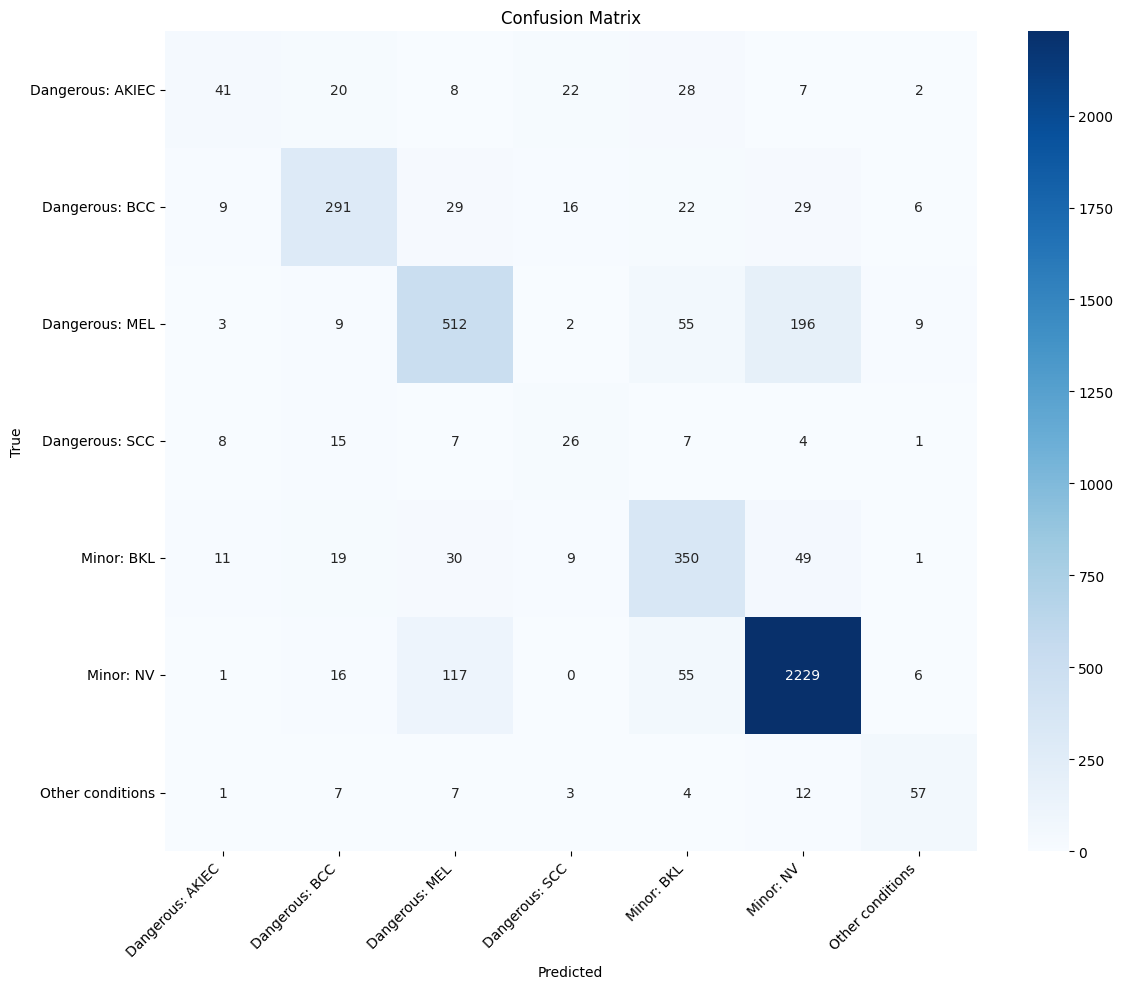


Classification Report:
                  precision    recall  f1-score   support

Dangerous: AKIEC       0.55      0.32      0.41       128
  Dangerous: BCC       0.77      0.72      0.75       402
  Dangerous: MEL       0.72      0.65      0.68       786
  Dangerous: SCC       0.33      0.38      0.36        68
      Minor: BKL       0.67      0.75      0.71       469
       Minor: NV       0.88      0.92      0.90      2424
Other conditions       0.70      0.63      0.66        91

        accuracy                           0.80      4368
       macro avg       0.66      0.62      0.64      4368
    weighted avg       0.80      0.80      0.80      4368

Model saved to '/content/skin_lesion_classifier.pth'


In [ ]:
!nvidia-smi
!pip install torch torchvision tqdm scikit-learn seaborn pandas matplotlib
# Basic imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

# Data processing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File and system utilities
import os
import time
import copy

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Mixed precision training
from torch.cuda.amp import autocast, GradScaler

# Progress bar
from tqdm import tqdm

# Image processing (if needed for denoising)
from PIL import Image
# Define configuration variables
IMAGE_SIZE = 224  # Smaller image size
BATCH_SIZE = 32   # Increase batch size if possible
NUM_EPOCHS = 20   # Fewer epochs
MODEL_TYPE = "mobilenet_v2"  # Lighter model

# Split the classified dataframe into train, validation, and test sets
train_df, temp_df = train_test_split(
    classified_df, test_size=0.3, random_state=42, stratify=classified_df['training_class']
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df['training_class']
)

print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

# Create a lighter model
num_classes = len(class_names)
model = create_model(MODEL_TYPE, num_classes)
model = model.to(device)

# Create simplified transforms
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Recreate data loaders with faster settings
train_loader = DataLoader(
    SkinLesionDataset(train_df, transform=train_transform),
    batch_size=BATCH_SIZE, shuffle=True,
    num_workers=4, pin_memory=True  # Faster data loading
)

val_loader = DataLoader(
    SkinLesionDataset(val_df, transform=val_test_transform),
    batch_size=BATCH_SIZE, num_workers=4, pin_memory=True
)

test_loader = DataLoader(
    SkinLesionDataset(test_df, transform=val_test_transform),
    batch_size=BATCH_SIZE, num_workers=4, pin_memory=True
)

# Use faster optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train with mixed precision
model, history = train_with_mixed_precision(
    model, train_loader, val_loader, nn.CrossEntropyLoss(),
    optimizer, scheduler=None, num_epochs=NUM_EPOCHS, device=device
)

# Evaluate and save model as before
test_acc, cm = evaluate_model(model, test_loader, class_names)
torch.save(model.state_dict(), '/content/skin_lesion_classifier.pth')
print("Model saved to '/content/skin_lesion_classifier.pth'")
